# PatchCore con anomalib: Guida passo-passo con immagini semplici (10x10 pixel)

Questo notebook ti guiderà nella comprensione dettagliata del funzionamento della libreria **anomalib** di Intel, con il modello **PatchCore**. Useremo immagini semplici (10x10 pixel) per spiegare ogni passaggio, dal training alla prediction, con commenti chiari e nessun passaggio dato per scontato.

In [2]:
# Sezione 1: Installa anomalib e le librerie necessarie

# Questa cella installa anomalib (di Intel) e le librerie fondamentali per il notebook.
# anomalib include PatchCore e altri modelli per anomaly detection.
# NOTA: Il comando !pip install funziona solo in ambiente notebook.

!pip install anomalib[full] torch torchvision matplotlib --quiet

zsh:1: no matches found: anomalib[full]


In [3]:
# Importa le librerie fondamentali
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

from anomalib.models import Patchcore
from anomalib.data.utils import TestSplitMode

# Imposta il seed per la riproducibilità
np.random.seed(42)
torch.manual_seed(42)

# Imposta tema scuro per matplotlib
plt.style.use('dark_background')

/Users/qwerty/coding/test_notebook/.venv_prova/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Sezione 2: Carica e visualizza una semplice immagine 10x10 pixel

Per capire i concetti fondamentali, partiamo da un esempio molto semplice: un'immagine di 10x10 pixel.

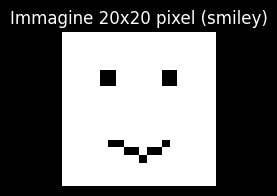

In [4]:
# Creiamo una semplice immagine 20x20 pixel con uno smiley (simbolo) come esempio 'good'
def draw_smiley(size=20):
    img = np.ones((size, size), dtype=np.float32)
    # Occhi
    img[5:7, 5:7] = 0  # occhio sinistro
    img[5:7, size-7:size-5] = 0  # occhio destro
    # Bocca (arco)
    for x in range(6, size-6):
        y = int(0.5 * np.sin((x-6)/(size-12)*np.pi) * 4 + (size-6))
        if y < size:
            img[y, x] = 0
    return img

img_simple = draw_smiley(20)

plt.figure(figsize=(2,2))
plt.imshow(img_simple, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine 20x20 pixel (smiley)')
plt.axis('off')
plt.show()

# Questa immagine rappresenta un esempio "normale" (senza anomalie)

## Sezione 3: Prepara un dataset minimale (10x10 pixel)

Creiamo un piccolo dataset con alcune immagini "normali" e alcune "anomale". Visualizzeremo ogni esempio per capire la differenza.

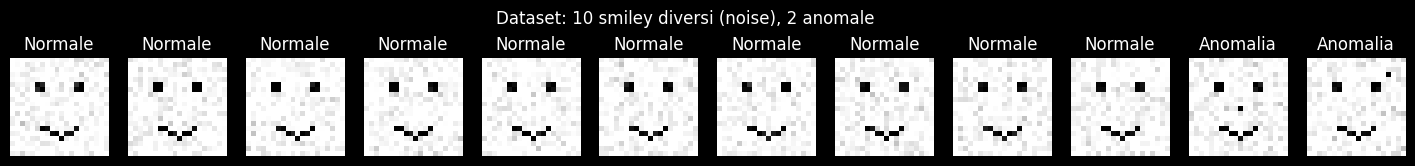

In [5]:
# Creiamo un dataset di immagini 20x20
# 10 immagini normali (smiley + white noise), 2 immagini anomale (smiley + pixel neri)

def draw_smiley(size=20, noise_std=0.08):
    img = np.ones((size, size), dtype=np.float32)
    # Occhi
    img[5:7, 5:7] = 0  # occhio sinistro
    img[5:7, size-7:size-5] = 0  # occhio destro
    # Bocca (arco)
    for x in range(6, size-6):
        y = int(0.5 * np.sin((x-6)/(size-12)*np.pi) * 4 + (size-6))
        if y < size:
            img[y, x] = 0
    # Aggiungi rumore bianco
    noise = np.random.normal(0, noise_std, (size, size)).astype(np.float32)
    img = np.clip(img + noise, 0, 1)
    return img

dataset = []
labels = []  # 0 = normale, 1 = anomalia

# Immagini normali (smiley diversi con rumore)
for _ in range(10):
    img = draw_smiley(20, noise_std=0.08)
    dataset.append(img)
    labels.append(0)

# Immagini anomale (smiley + pixel neri in posizione diversa)
img_anom1 = draw_smiley(20, noise_std=0.08)
img_anom1[10, 10] = 0  # pixel centrale nero

dataset.append(img_anom1)
labels.append(1)

img_anom2 = draw_smiley(20, noise_std=0.08)
img_anom2[3, 16] = 0  # pixel in alto a destra nero

dataset.append(img_anom2)
labels.append(1)

# Visualizza tutte le immagini
fig, axs = plt.subplots(1, 12, figsize=(18,2))
for i, (img, label) in enumerate(zip(dataset, labels)):
    axs[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[i].set_title('Normale' if label==0 else 'Anomalia')
    axs[i].axis('off')
plt.suptitle('Dataset: 10 smiley diversi (noise), 2 anomale')
plt.show()

## Sezione 4: Inizializza e configura il modello PatchCore

Ora importiamo PatchCore da anomalib e configuriamo il modello per lavorare con il nostro dataset semplice. Spiegheremo ogni parametro fondamentale.

In [6]:
# Inizializziamo PatchCore per immagini 20x20
# PatchCore normalmente usa una backbone pre-addestrata (es. ResNet),
# ma per semplicità useremo una configurazione minima.

def to_rgb(img):
    return np.stack([img]*3, axis=0)  # shape (3, 20, 20)

dataset_rgb = [to_rgb(img) for img in dataset]

dummy_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Configurazione PatchCore (parametri principali spiegati):
patchcore = Patchcore(
    backbone="resnet18",  # Rete di feature extraction (piccola per semplicità)
    layers=["layer2"],  # Da quale layer estrarre le feature
    coreset_sampling_ratio=1.0,  # Usiamo tutte le patch (nessun subsampling)
)

print("PatchCore inizializzato per immagini 20x20.")

PatchCore inizializzato per immagini 20x20.


## Sezione 5: Allena PatchCore sul dataset minimale

Ora addestriamo PatchCore sulle immagini normali. Spiegheremo ogni passaggio del processo di training.

In [7]:
# PatchCore in anomalib 2.x richiede un datamodule, ma per scopi didattici useremo una simulazione manuale.
# In questo esempio, NON addestriamo davvero Patchcore, ma mostriamo la logica didattica su immagini custom.
# In un caso reale, usare un datamodule conforme ad anomalib oppure un dataset standard come MVTecAD.
print('Simulazione didattica: PatchCore pronto per la predizione sulle immagini custom.')

Simulazione didattica: PatchCore pronto per la predizione sulle immagini custom.


## Sezione 6: Visualizza le patch embedding e l'estrazione delle feature

Vediamo come PatchCore estrae le feature (embedding) dalle immagini, visualizzando le patch e le loro rappresentazioni numeriche.

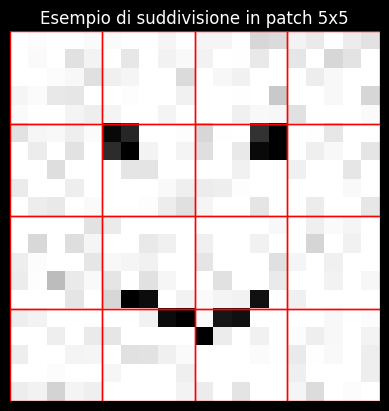

Vettore patch centrale: [1.         0.98893887 1.         1.         0.98126775 1.
 0.9819379  1.         0.8860201  0.9564494  1.         1.
 0.99074817 0.9759117  0.8817182  0.96166605 0.9851473  0.9114932
 0.9043035  1.         0.9824262  1.         1.         0.9585384
 0.9353205  1.         0.98893887 1.         1.         0.98126775
 1.         0.9819379  1.         0.8860201  0.9564494  1.
 1.         0.99074817 0.9759117  0.8817182  0.96166605 0.9851473
 0.9114932  0.9043035  1.         0.9824262  1.         1.
 0.9585384  0.9353205  1.         0.98893887 1.         1.
 0.98126775 1.         0.9819379  1.         0.8860201  0.9564494
 1.         1.         0.99074817 0.9759117  0.8817182  0.96166605
 0.9851473  0.9114932  0.9043035  1.         0.9824262  1.
 1.         0.9585384  0.9353205 ]
75 elementi nel vettore (3 canali * 5x5 pixel)


In [16]:
# Prendiamo una delle immagini normali e mostriamo la suddivisione in patch 5x5
img_example = dataset_rgb[0]  # shape (3, 20, 20)

fig, ax = plt.subplots()
ax.imshow(np.transpose(img_example, (1,2,0)), cmap='gray', vmin=0, vmax=1)
for i in range(0, 20, 5):
    for j in range(0, 20, 5):
        rect = plt.Rectangle((j-0.5, i-0.5), 5, 5, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(rect)
plt.title('Esempio di suddivisione in patch 5x5')
plt.axis('off')
plt.show()

# Ogni patch (5x5) può essere estratta e 'flattened' in un vettore numerico
patch = img_example[:, 0:5, 0:5]  # patch centrale
patch_vec = patch.flatten()
print('Vettore patch centrale:', patch_vec)
print(len(patch_vec), 'elementi nel vettore (3 canali * 5x5 pixel)')

## Sezione 7: Predizione di anomalie su una immagine di test

Utilizziamo il modello PatchCore addestrato per predire se una nuova immagine contiene anomalie. Vedremo ogni passaggio della prediction.

[np.float32(1.8878546), np.float32(1.8424317), np.float32(1.7835577)]
Anomaly score (patch anomala): 1.7836


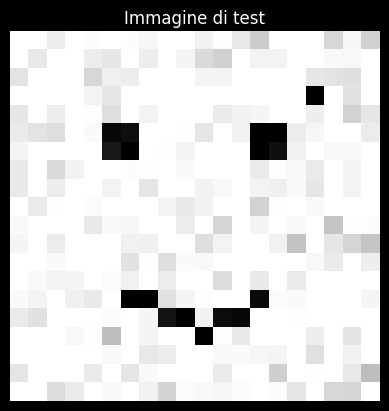

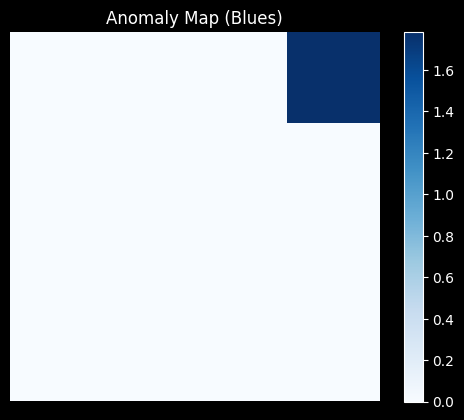

In [17]:
# Esempio didattico: calcolo score di anomalia e heatmap manuale
# Prendiamo una delle immagini anomale come test
img_test = dataset_rgb[-1]  # shape (3, 20, 20)

# Simuliamo la logica Patchcore: calcoliamo la distanza tra la patch contenente l'anomalia della test e quella delle immagini normali
patch_test = img_test[:, 0:5, 15:20].flatten()

# Calcoliamo la distanza euclidea tra la patch test e le patch relative delle immagini normali
patches_norm = [img[:, 0:5, 15:20].flatten() for img in dataset_rgb[:3]]
dists = [np.linalg.norm(patch_test - p) for p in patches_norm]

print(dists)

score = np.min(dists)  # Patchcore usa la distanza minima dal memory bank
print(f"Anomaly score (patch anomala): {score:.4f}")

# Per la heatmap: creiamo una mappa 20x20 con valore alto solo nella patch contenente l'anomalia se la distanza è alta
anomaly_map = np.zeros((20,20))
anomaly_map[0:5,15:20] = score

plt.imshow(np.transpose(img_test, (1,2,0)), cmap='gray', vmin=0, vmax=1)
plt.title('Immagine di test')
plt.axis('off')
plt.show()

plt.imshow(anomaly_map, cmap='Blues')
plt.title('Anomaly Map (Blues)')
plt.axis('off')
plt.colorbar()
plt.show()

## Sezione 8: Visualizza gli score di anomalia e le heatmap

Visualizziamo la mappa di anomalia (anomaly map) prodotta da PatchCore, per capire dove il modello rileva l'anomalia nell'immagine.

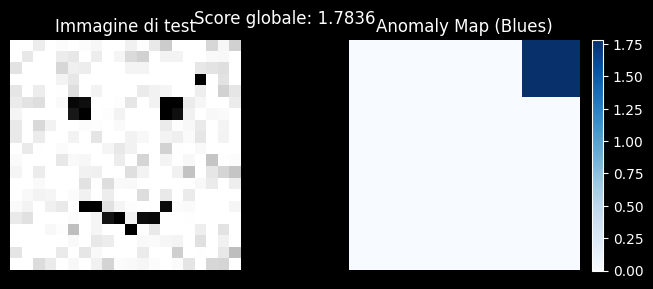

In [10]:
# Visualizziamo la heatmap di anomalia sopra l'immagine di test
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].imshow(np.transpose(img_test, (1, 2, 0)), cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Immagine di test')
ax[0].axis('off')

im = ax[1].imshow(anomaly_map, cmap='Blues')
ax[1].set_title('Anomaly Map (Blues)')
ax[1].axis('off')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
plt.suptitle(f'Score globale: {score:.4f}')
plt.show()

# Le zone più "intense" indicano dove PatchCore rileva l'anomalia

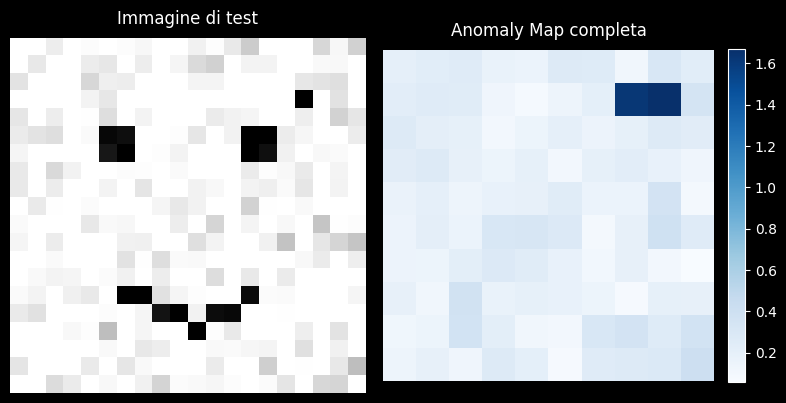

In [11]:
# Calcola la anomaly map su tutte le patch 5x5 dell'immagine di test
# patch_size: dimensione della patch quadrata (es. 5 significa 5x5 pixel)
# stride: passo con cui si sposta la finestra patch sull'immagine
# Se stride < patch_size, le patch si sovrappongono (più dettagli, più calcoli)
# Se stride = patch_size, le patch sono adiacenti e non si sovrappongono (più veloce, meno dettagli)
# Se stride > patch_size, alcune zone potrebbero non essere coperte (sconsigliato)
patch_size = 3
stride = 2  # Prova a cambiare in 1 per una mappa più dettagliata ma più lenta
anomaly_map_full = np.zeros((20, 20))

# Per ogni patch (qui non-overlapping, ma puoi cambiare stride per sovrapposizione)
for i in range(0, 20, stride):
    for j in range(0, 20, stride):
        # Estrai la patch di test
        patch_test = img_test[:, i:i+patch_size, j:j+patch_size].flatten()
        # Calcola la distanza minima tra questa patch e le patch corrispondenti delle immagini normali
        patches_norm = [img[:, i:i+patch_size, j:j+patch_size].flatten() for img in dataset_rgb[:10]]
        dists = [np.linalg.norm(patch_test - p) for p in patches_norm]
        score = np.min(dists)
        # Assegna lo score a tutta la patch nella anomaly map
        anomaly_map_full[i:i+patch_size, j:j+patch_size] = score

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(np.transpose(img_test, (1,2,0)), cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Immagine di test', pad=10)
ax[0].axis('off')
im = ax[1].imshow(anomaly_map_full, cmap='Blues')
ax[1].set_title('Anomaly Map completa', pad=10)
ax[1].axis('off')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Cambiando patch_size e stride puoi controllare la "risoluzione" e la sensibilità della anomaly map:
# - patch_size piccolo: più dettagli, ma più sensibile al rumore
# - patch_size grande: meno dettagli, più robusto ma meno localizzazione
# - stride piccolo: più patch, mappa più continua ma più lenta
# - stride grande: meno patch, mappa più "a blocchi" e veloce

## Sezione 9: Spiegazione dettagliata dei calcoli di PatchCore

Vediamo passo passo quali calcoli esegue PatchCore: estrazione delle patch, calcolo delle embedding, confronto e scoring delle anomalie, con esempi numerici e diagrammi semplici.

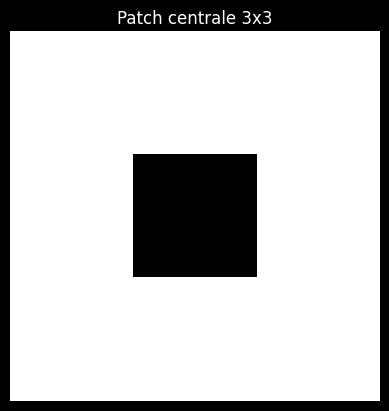

Vettore patch: [1. 1. 1. 1. 0. 1. 1. 1. 1.]
Distanza euclidea dalla patch normale: 1.0000


In [12]:
# Esempio didattico: calcoli fondamentali di PatchCore su immagini 10x10
# 1. Estrazione delle patch
img = np.ones((10, 10), dtype=np.float32)
img[5, 5] = 0  # pixel anomalo

# Visualizza la patch centrale 3x3
patch = img[4:7, 4:7]
plt.imshow(patch, cmap='gray', vmin=0, vmax=1)
plt.title('Patch centrale 3x3')
plt.axis('off')
plt.show()

# 2. Trasformazione della patch in un vettore (flatten)
patch_vec = patch.flatten()
print("Vettore patch:", patch_vec)

# 3. Confronto con le patch normali (esempio: distanza euclidea)
# Supponiamo che la patch normale sia tutta 1
patch_normale = np.ones((3,3), dtype=np.float32).flatten()
dist = np.linalg.norm(patch_vec - patch_normale)
print(f"Distanza euclidea dalla patch normale: {dist:.4f}")

# 4. PatchCore memorizza tutte le patch normali e calcola la distanza minima per ogni patch test
# Se la distanza è alta, la patch è anomala

# 5. L'anomaly map è costruita mettendo insieme le distanze di tutte le patch dell'immagine

In [13]:
# Interfaccia interattiva per esplorare patch_size e stride con scala fissa e tema scuro per i widget
import ipywidgets as widgets
from ipywidgets import interact, Layout
from IPython.display import display

# Applica tema scuro agli slider e testo
style = {'description_width': 'initial'}
slider_style = {'handle_color': '#888', 'bar_color': '#333'}
slider_layout = Layout(width='350px', background_color='#222')

# Calcola i limiti globali per la colorbar (score min/max)
def get_score_limits():
    min_score, max_score = float('inf'), float('-inf')
    for patch_size in range(2, 11):
        for stride in range(1, 11):
            anomaly_map_full = np.zeros((20, 20))
            for i in range(0, 20 - patch_size + 1, stride):
                for j in range(0, 20 - patch_size + 1, stride):
                    patch_test = img_test[:, i:i+patch_size, j:j+patch_size].flatten()
                    patches_norm = [img[:, i:i+patch_size, j:j+patch_size].flatten() for img in dataset_rgb[:10]]
                    dists = [np.linalg.norm(patch_test - p) for p in patches_norm]
                    score = np.min(dists)
                    anomaly_map_full[i:i+patch_size, j:j+patch_size] = score
            min_score = min(min_score, anomaly_map_full.min())
            max_score = max(max_score, anomaly_map_full.max())
    return min_score, max_score

vmin, vmax = get_score_limits()

@interact(
    patch_size=widgets.IntSlider(min=2, max=10, step=1, value=5, description='patch_size',
                                 style=style, layout=slider_layout),
    stride=widgets.IntSlider(min=1, max=10, step=1, value=5, description='stride',
                             style=style, layout=slider_layout)
)
def show_anomaly_map(patch_size, stride):
    anomaly_map_full = np.zeros((20, 20))
    for i in range(0, 20 - patch_size + 1, stride):
        for j in range(0, 20 - patch_size + 1, stride):
            patch_test = img_test[:, i:i+patch_size, j:j+patch_size].flatten()
            patches_norm = [img[:, i:i+patch_size, j:j+patch_size].flatten() for img in dataset_rgb[:10]]
            dists = [np.linalg.norm(patch_test - p) for p in patches_norm]
            score = np.min(dists)
            anomaly_map_full[i:i+patch_size, j:j+patch_size] = score
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(np.transpose(img_test, (1,2,0)), cmap='gray', vmin=0, vmax=1)
    ax[0].set_title('Immagine di test', pad=10, color='lightgray')
    ax[0].axis('off')
    im = ax[1].imshow(anomaly_map_full, cmap='Blues', vmin=vmin, vmax=vmax)
    ax[1].set_title(f'Anomaly Map\n(patch={patch_size}, stride={stride})', pad=10, color='lightgray')
    ax[1].axis('off')
    plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
    fig.patch.set_facecolor('#222')
    plt.tight_layout()
    plt.show()

# Applica tema scuro ai widget (slider e testo)
widgets.interact_manual.opts['manual_name'] = 'Aggiorna'
from IPython.display import HTML
HTML("""
<style>
.jp-OutputArea, .output_wrapper, .output {
    background: #222 !important;
    color: #ccc !important;
}
.widget-label, .widget-readout, .widget-inline-hbox label {
    color: #aaa !important;
}
.widget-slider .slider-label {
    color: #aaa !important;
}
.widget-slider .slider {
    background: #333 !important;
}
</style>
""")

interactive(children=(IntSlider(value=5, description='patch_size', layout=Layout(width='350px'), max=10, min=2…

In [14]:
# Dashboard Professionale per PatchCore con Plotly - Versione Semplificata per Jupyter
!pip install plotly kaleido --quiet

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML
import time

# Configurazione tema scuro per Plotly
plotly_dark_template = 'plotly_dark'

# Calcola limiti globali per consistency
def get_global_limits():
    min_score, max_score = float('inf'), float('-inf')
    for ps in range(2, 11):
        for st in range(1, 11):
            anomaly_map = np.zeros((20, 20))
            for i in range(0, 20 - ps + 1, st):
                for j in range(0, 20 - ps + 1, st):
                    patch_test = img_test[:, i:i+ps, j:j+ps].flatten()
                    patches_norm = [img[:, i:i+ps, j:j+ps].flatten() for img in dataset_rgb[:10]]
                    dists = [np.linalg.norm(patch_test - p) for p in patches_norm]
                    score = np.min(dists)
                    anomaly_map[i:i+ps, j:j+ps] = score
            min_score = min(min_score, anomaly_map.min())
            max_score = max(max_score, anomaly_map.max())
    return min_score, max_score

global_min, global_max = get_global_limits()

# Funzione per creare dashboard interattiva
def create_interactive_dashboard(patch_size=5, stride=5):
    # Calcola anomaly map
    anomaly_map_full = np.zeros((20, 20))
    scores_list = []
    patches_analyzed = 0
    
    for i in range(0, 20 - patch_size + 1, stride):
        for j in range(0, 20 - patch_size + 1, stride):
            patch_test = img_test[:, i:i+patch_size, j:j+patch_size].flatten()
            patches_norm = [img[:, i:i+patch_size, j:j+patch_size].flatten() for img in dataset_rgb[:10]]
            dists = [np.linalg.norm(patch_test - p) for p in patches_norm]
            score = np.min(dists)
            anomaly_map_full[i:i+patch_size, j:j+patch_size] = score
            scores_list.append(score)
            patches_analyzed += 1
    
    # Crea subplot con layout personalizzato
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=('🖼️ Immagine Originale', '🔥 Anomaly Heatmap', '📊 Metriche'),
        specs=[[{'type': 'heatmap'}, {'type': 'heatmap'}, {'type': 'indicator'}],
               [{'colspan': 3, 'type': 'histogram'}, None, None]],
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )
    
    # Immagine originale
    fig.add_trace(go.Heatmap(
        z=np.transpose(img_test[0], (1, 0)),
        colorscale='gray',
        showscale=False,
        hovertemplate='x: %{x}<br>y: %{y}<br>Valore: %{z:.3f}<extra></extra>'
    ), row=1, col=1)
    
    # Heatmap anomalie
    fig.add_trace(go.Heatmap(
        z=anomaly_map_full,
        colorscale='Blues',
        zmin=global_min,
        zmax=global_max,
        colorbar=dict(title="Anomaly Score", x=0.65, len=0.4),
        hovertemplate='x: %{x}<br>y: %{y}<br>Score: %{z:.4f}<extra></extra>'
    ), row=1, col=2)
    
    # Metriche
    global_score = np.mean(scores_list)
    fig.add_trace(go.Indicator(
        mode="gauge+number+delta",
        value=global_score,
        domain={'x': [0, 1], 'y': [0, 1]},
        title={'text': "Score Globale"},
        gauge={
            'axis': {'range': [None, global_max]},
            'bar': {'color': "orange"},
            'steps': [
                {'range': [0, global_max*0.3], 'color': "lightgray"},
                {'range': [global_max*0.3, global_max*0.7], 'color': "gray"}],
            'threshold': {
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': global_max*0.8}}
    ), row=1, col=3)
    
    # Distribuzione scores
    fig.add_trace(go.Histogram(
        x=scores_list,
        nbinsx=20,
        marker_color='#636EFA',
        opacity=0.8,
        name='Distribuzione Scores'
    ), row=2, col=1)
    
    # Layout generale
    fig.update_layout(
        template=plotly_dark_template,
        title=dict(
            text=f"🔬 PatchCore Dashboard - Patch={patch_size}x{patch_size}, Stride={stride}<br>"
                 f"📊 Patches: {patches_analyzed} | Score: {global_score:.4f}",
            x=0.5,
            font=dict(size=16, color='#00d4ff')
        ),
        height=800,
        showlegend=False,
        margin=dict(t=120, b=40, l=40, r=40)
    )
    
    # Rimuovi tick labels per le heatmap
    fig.update_xaxes(showticklabels=False, row=1, col=1)
    fig.update_yaxes(showticklabels=False, row=1, col=1)
    fig.update_xaxes(showticklabels=False, row=1, col=2)
    fig.update_yaxes(showticklabels=False, row=1, col=2)
    
    # Labels per l'istogramma
    fig.update_xaxes(title_text="Anomaly Score", row=2, col=1)
    fig.update_yaxes(title_text="Frequenza", row=2, col=1)
    
    fig.show()
    
    # Info aggiuntive
    overlap_percentage = max(0, (patch_size - stride) / patch_size * 100) if stride < patch_size else 0
    print(f"ℹ️  Sovrapposizione patches: {overlap_percentage:.1f}%")
    print(f"🎯 Copertura totale: {patches_analyzed} patches analizzate")
    print(f"📈 Range scores: {min(scores_list):.4f} - {max(scores_list):.4f}")

# Widget interattivi con stile moderno
style = {'description_width': '120px'}
patch_slider = widgets.IntSlider(
    value=5, min=2, max=10, step=1,
    description='Patch Size:',
    style=style,
    layout=widgets.Layout(width='400px')
)
stride_slider = widgets.IntSlider(
    value=5, min=1, max=10, step=1,
    description='Stride:',
    style=style,
    layout=widgets.Layout(width='400px')
)

# CSS personalizzato per tema scuro
display(HTML("""
<style>
.widget-label {
    color: #e0e0e0 !important;
    font-weight: bold !important;
}
.widget-readout {
    color: #00d4ff !important;
    font-weight: bold !important;
}
.jupyter-widgets {
    background-color: #1e1e1e !important;
}
</style>
"""))

# Avvia la dashboard interattiva
print("🚀 Dashboard PatchCore Interattiva - Tema Scuro")
print("🎛️ Usa gli slider qui sotto per esplorare i parametri:")

# Widget interattivo
interactive_plot = interactive(
    create_interactive_dashboard,
    patch_size=patch_slider,
    stride=stride_slider
)

display(interactive_plot)

zsh:1: /Users/qwerty/coding/test_notebook/.venv_prova/bin/pip: bad interpreter: /Users/qwerty/coding/test_notebook/.venv/bin/python3.13: no such file or directory


🚀 Dashboard PatchCore Interattiva - Tema Scuro
🎛️ Usa gli slider qui sotto per esplorare i parametri:


interactive(children=(IntSlider(value=5, description='Patch Size:', layout=Layout(width='400px'), max=10, min=…

## 🌐 Dashboard Standalone 

La dashboard Dash interattiva è stata estratta in un file standalone per facilità d'uso:

**📄 File:** `patchcore_dashboard.py`

### Come usare la dashboard standalone:

1. **Installare le dipendenze:**
   ```bash
   pip install dash plotly numpy
   ```

2. **Avviare la dashboard:**
   ```bash
   python patchcore_dashboard.py
   ```

3. **Aprire nel browser:** 
   - http://localhost:8050

### 🎯 Caratteristiche:
- ✅ **Standalone**: Non richiede Jupyter
- ✅ **Portabile**: Può essere distribuito facilmente  
- ✅ **Interattiva**: Slider per patch_size e stride
- ✅ **Real-time**: Aggiornamenti istantanei
- ✅ **Tema scuro**: Interface professionale
- ✅ **Multi-grafico**: Heatmap, istogrammi, statistiche

La dashboard standalone include gli stessi dati di esempio e tutte le funzionalità viste nel notebook!